<a href="https://colab.research.google.com/github/stephenbrutch/Machine-Learning-Projects/blob/main/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

The goal of this notebook is to get familiar with working with time series data


**Goal: To predict the price of Bitcoin**



#Getting Started

In [ ]:
#check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-dfbbf697-283e-ec28-19c5-5c1070da859f)


In [ ]:
#Get data. Data used today is BTC price data from 01,Oct 2013 -> 18, May 2021
#Download data from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv and upload it

In [ ]:
# Import with pandas
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


Because we told pandas to parse the date column and set it as the index, its not in the list of columns

In [ ]:
#how many sample do we have
len(df)

2787

We have BTC price data from 2013 to 2021 but we only have 2787 entries of data! This can sometimes be the issue with time series problems. Looks like we have a sampling of only 1 per day, machine learning algorithms usually flourish with lots of data.

Lets simplify our data since that closing price is what we are concerned with

In [ ]:
#only want closing price for each date
bitcoin_prices=pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


# Data Visualization

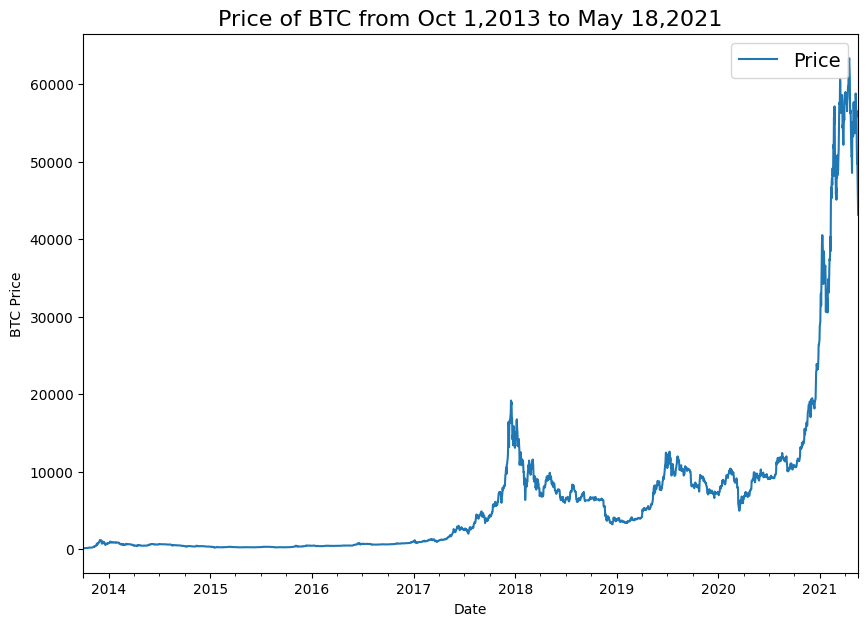

In [ ]:
#Lets visualize our data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))

plt.ylabel("BTC Price")
plt.title("Price of BTC from Oct 1,2013 to May 18,2021",fontsize=16)
plt.legend(fontsize=14)

Let's see how we can replicate the plot we created before except this time using Python's csv and datetime modules.

In [ ]:
#importing and formatting historical BTC data with Python
import csv
from datetime import datetime

timesteps=[]
btc_price=[]
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader=csv.reader(f,delimiter=",") #read in the target csv
  next(csv_reader) #skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1],"%Y-%m-%d")) #get the dates as dates (not strings). strptime = string parse time
    btc_price.append(float(line[2])) #get the closing price as float

#view first 10 of each
timesteps[:10],btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

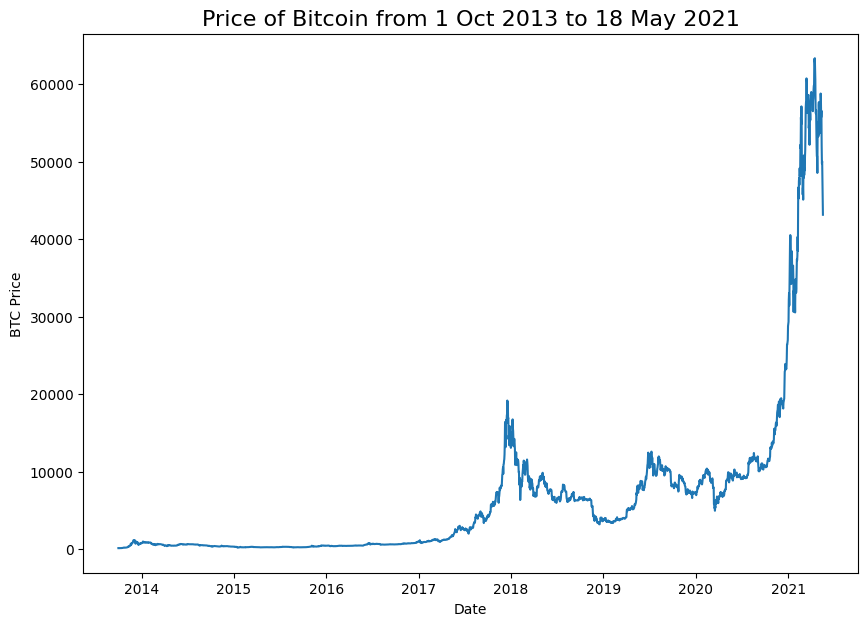

In [ ]:
#Lets visualize method 2
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

#Create train and test sets for time series data

Because we are working with time series data (sequential data) we have to create the train and test split differently than normally, i.e. we cant just use sci-kit-learn's train_test_split.

In time series problems, youll either have univariate or multivariate data
* **Univariate** time series data deals with one variable, for example, using the price of Bitcoin to predict the price of Bitcoin
* **Multivariate** time series data deals with more than one variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region

In our time series problem we have a univariate time series. (for multivariate time series, you will have to split multiple variables).

## Create train and test sets THE WRONG WAY

In [ ]:
#Get BTC date array
timesteps=bitcoin_prices.index.to_numpy()
prices=bitcoin_prices["Price"].to_numpy()

timesteps[:10],prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
#wrong way to make a train test split for time series
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(timesteps,
                                               prices,
                                               test_size=0.2,
                                               random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2229,), (558,), (2229,), (558,))

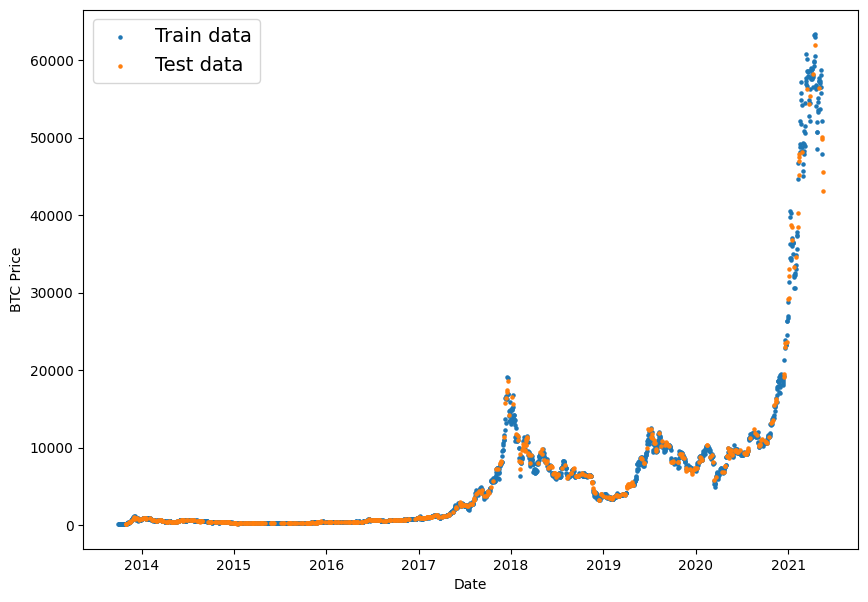

In [ ]:
#Visualize the newly formed variables
plt.figure(figsize=(10,7))

plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

Our test data is scattered all throughout the training data.

This kind of random split is okay for datasets without a time component (such as images or passages of text for classification problems) but for time series, we've got to take the time factor into account.

To fix this, we've got to split our data in a way that reflects what we're actually trying to do.

We need to split our historical Bitcoin data to have a dataset that reflects the past (train set) and a dataset that reflects the future (test set).

## Create the train and test sets THE RIGHT WAY

Instead of randomly splitting our data in a scattered way we can engineer it in such a way we select an arbitrary point in time and let the points before that be the TRAIN set and the points after that be the TEST/VALIDATION set

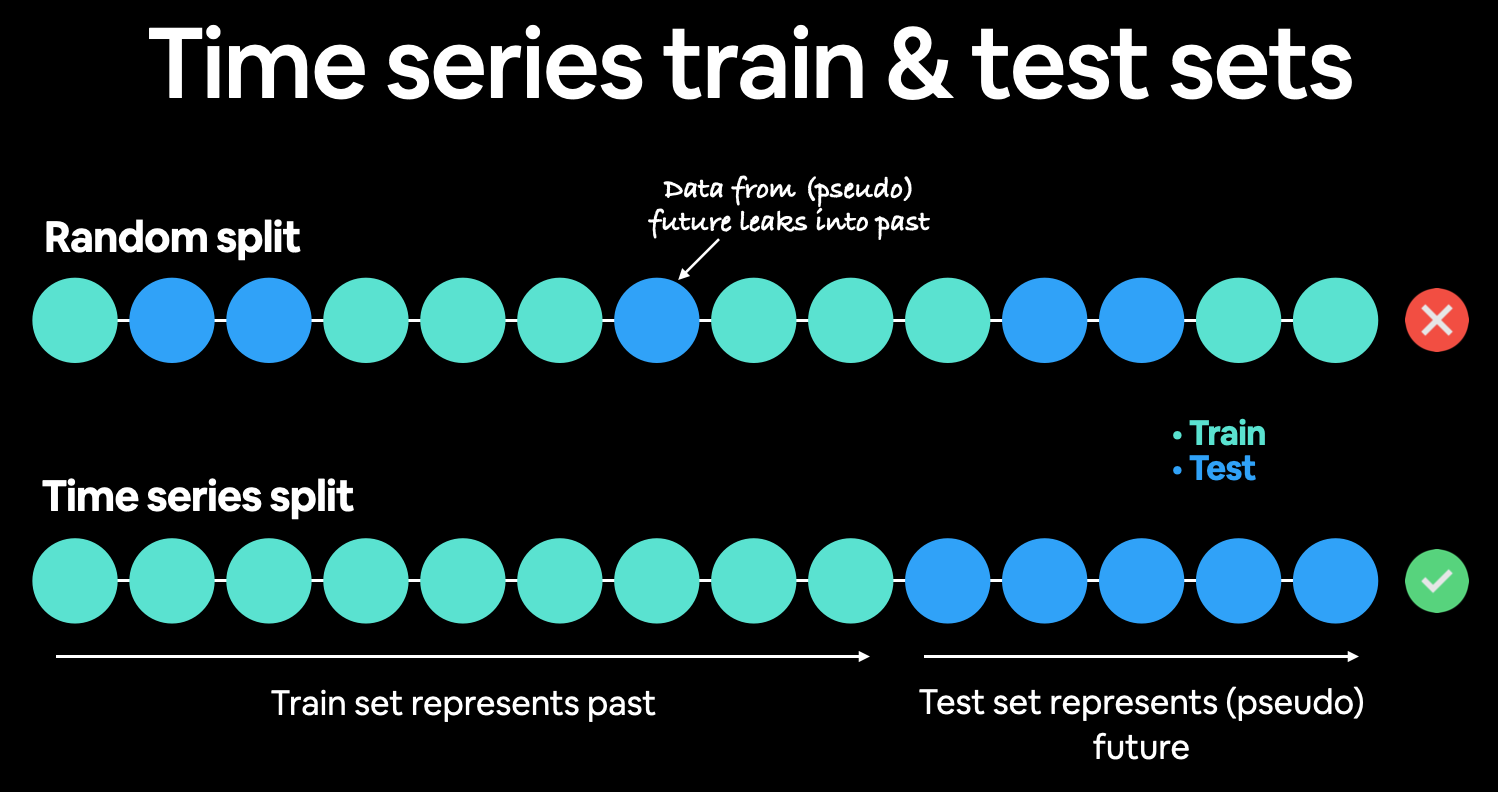

In [ ]:
#Create train and test splits the right way
split_size=int(0.8*len(prices)) #80/20 split

#Create train data splits (everything before the split)
X_train,y_train=timesteps[:split_size],prices[:split_size]

#Create test data splits (everything after the split)
X_test,y_test=timesteps[split_size:],prices[split_size:]

len(X_train),len(X_test),len(y_train),len(y_test)

(2229, 558, 2229, 558)

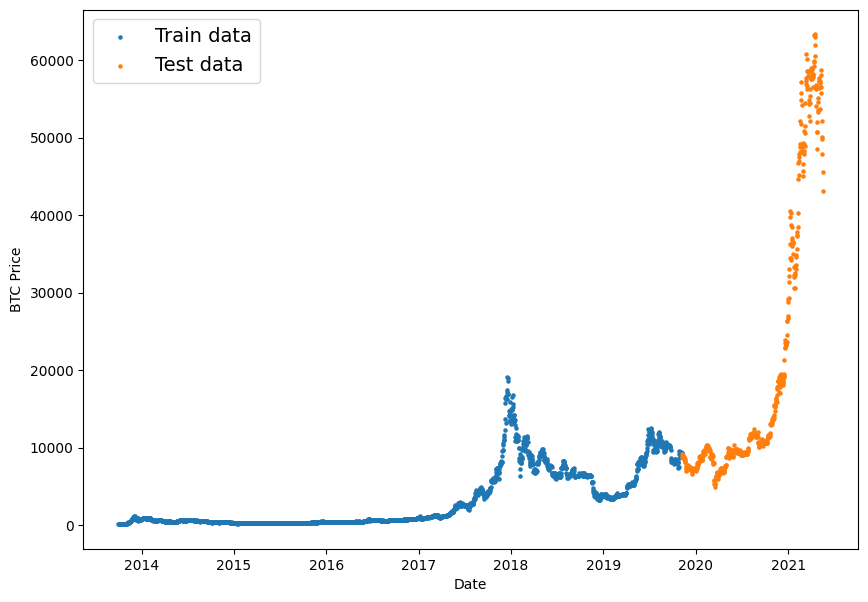

In [ ]:
#Lets visualize the newly formed variables
plt.figure(figsize=(10,7))

plt.scatter(X_train,y_train,s=5,label="Train data")
plt.scatter(X_test,y_test,s=5,label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

The amount of data we reserved for our test set is not set in stone-we could have done 85/15,90/10,... The main point is that the test set is a sort of pseudofuture data and not actual future data (we cant evaluate predictions on data labels we dont have)

# Create plotting function

In [ ]:
#create a function to plot time series data

def plot_time_series(timesteps,values,format='.',start=0,end=None,label=None):
  '''
  Plots a timesteps (a series of points in time) against values(a series of values across timesteps)

  Parameters
  ----------
  timesteps:array of timesteps
  values:array of values across time
  format:style of plot, default "."
  start:where to start the plot (setting a value will index from start of timesteps and values)
  end:where to end the plot (setting a value will index from end of timesteps and values)
  label:label to show on plot of values
  '''

  #plot the series
  plt.plot(timesteps[start:end],values[start:end],format,label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

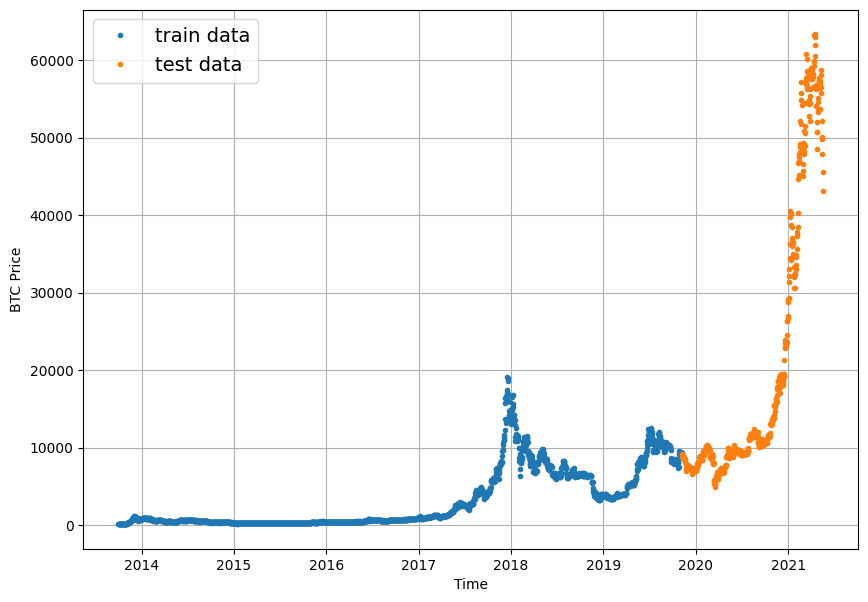

In [ ]:
#try out our plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="train data")
plot_time_series(timesteps=X_test,values=y_test,label="test data")

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly. However, just because we can build almost any kind of model, doesn't mean it'll perform well/should be used in a production setting.

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, horizon and window.
* horizon = number of timesteps to predict into future
* window = number of timesteps from past used to predict horizon

For example, if we wanted to predict the price of BTC for tomorrow-1 day in the future, using the previous weeks worth of BTC prices-7 days in the past, the horizon would be 1 and the window would be 7

# Model 0: Naive-baseline

One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all. That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

$\hat{y}_t = y_{t-1}$

In english: the prediction at timestep t ($\hat{y}$) is equal to the value at timestep t-1 (the previous timestep).


In [ ]:
#create a naive forecast
naive_forecast=y_test[:-1] #naive forecast equals every value excluding the last value

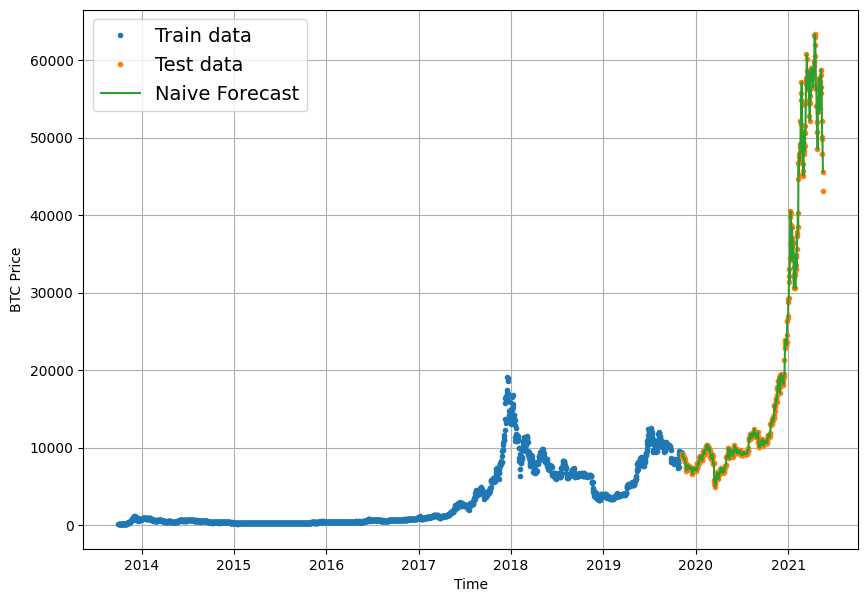

In [ ]:
#plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

plot_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",label="Naive Forecast")

Lets zoom in to take a better look at just how well the naive forecast is doing

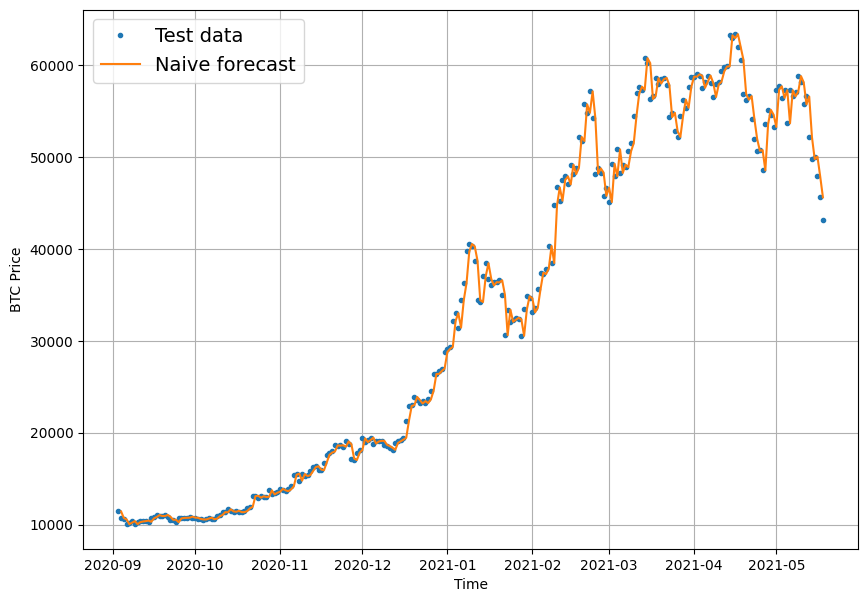

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

# Evaluating the time series problem

-Scale dependent error
* MAE: mean absolute error
* RMSE: root mean square error

-Percentage error
* MAPE: mean absolute percentage error
* sMAPE: symmetric mean absolute percentage error

-Scaled error
* MASE: mean absolute scaled error

## Lets create a function to calculate the metrics

In [ ]:
#Lets import tensorflow
import tensorflow as tf

In [ ]:
#MASE implemented courtesy of sktime -  https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab05
def mean_absolute_scaled_error(y_true,y_pred):
  '''
  Implement MASE (assuming no seasonality of data)
  '''
  mae=tf.reduce_mean(tf.abs(y_true-y_pred))

  #Find MAE of naive forecast (no seasonality)
  mae_naive_no_season=tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)


  return mae/mae_naive_no_season

In [ ]:
def evaluate_preds(y_true,y_pred):

  #make sure float32(for metric calculations)
  y_true=tf.cast(y_true,dtype=tf.float32)
  y_pred=tf.cast(y_pred,dtype=tf.float32)

  #calculate various metrics
  mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse=tf.keras.metrics.mean_squared_error(y_true,y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse=tf.sqrt(mse)
  mape=tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase=mean_absolute_scaled_error(y_true,y_pred)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy(),
          "mase":mase.numpy()}

In [ ]:
naive_results=evaluate_preds(y_true=y_test[1:],
                             y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

mae is mean absolute error and its value is 567 so the average error of each forecast of BTC is about $567

In [ ]:
#Lets compare to the average price of BTC of the test dataset
#find average price of BTC in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

# Format data part 2

For example for a univariate time series, windowing for one week (window=7) to predict the next single value (horizon=1) might look like:



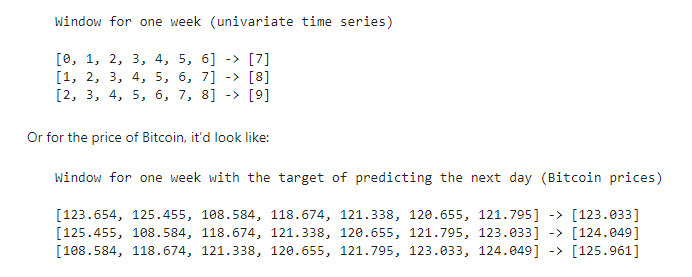

## Lets build a function for windowing and horizoning

In [ ]:
HORIZON=1 #predict 1 step at a time
WINDOW_SIZE=7 #use a weeks worth of timestpes to predict the horizon

Now we'll write a function to take in an array and turn it into a window and horizon.

In [ ]:
#create function to label windowed data
def get_labelled_windows(x,horizon=1):
  '''
  Creates labels for windowed dataset.

  e.g. if horizon=1 (default)
  input: [1,2,3,4,5,6] -> output([1,2,3,4,5],[6])
  '''
  return x[:,:-horizon],x[:,-horizon:]

In [ ]:
#test out the the window labelling function function
test_window,test_label=get_labelled_windows(tf.expand_dims(tf.range(8)+1,axis=0),horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


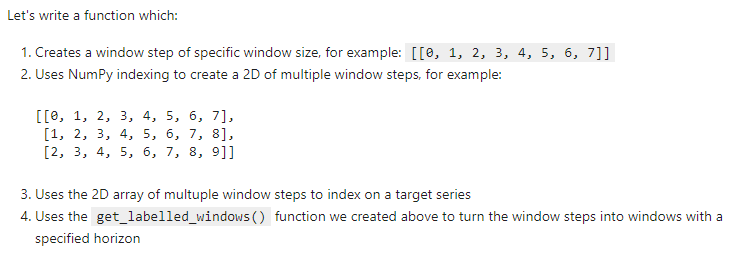

In [ ]:
#create function to view numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows,full_labels=make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(2780, 2780)

In [ ]:
#lets visualize
#view the first 3 windows/labels

for i in range(3):
  print(f"window: {full_windows[i]} -> Labels: {full_labels[i]}")

window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Labels: [123.033]
window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Labels: [124.049]
window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Labels: [125.96116]


In [ ]:
#view the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Labels: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Labels: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Labels: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Labels: [43144.47129086]


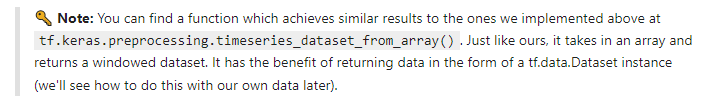

## Turning windows into training and test sets

Time to turn our windows into training and test splits.

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

Let's write a function which takes in full sets of windows and their labels and splits them into train and test splits.

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
#check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]),y_train[WINDOW_SIZE:])

True

# Make a modeling checkpoint

Because our models performance will fluctuate from experiment to experiment we'll want to make sure were comparing apples to apples = for fair comparison compare each models best performance

For example if model_1 performed well on epoch 55 we want to compare model_1 on epoch 55 to save that for comparison


In [ ]:
#create a function to create a modelcheckpoint callback which saves a model to specified filename
import os

#Create a function to implement a modelcheckpoint callback with a specified filename
def create_model_checkpoint(model_name,save_path="model_experiments"):
  return tf.keras.callback.Model_Checkpoint(filepath=os.path.join(save_path,model_name), #create filepath to
                                            verbose=0, #only output a limited amount of text
                                            save_best_only=True) #save only the best model to file

# Model 1: Dense model (window=7,horizon=1)

* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae',patience=2)

In [ ]:
#set random seed for as reproducable results as possible
tf.random.set_seed(42)

#construct model
model_1=tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON,activation="linear")
],name="model_1_dense")

#compile the model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

In [ ]:
#fit the model
history=model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            #callbacks=[[early_stopping]]
            )

Epoch 1/100
18/18 [==============================] - 6s 16ms/step - loss: 1399.3400 - mae: 1399.3400 - val_loss: 1870.5831 - val_mae: 1870.5831
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 335.8326 - mae: 335.8326 - val_loss: 1766.3726 - val_mae: 1766.3726
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 215.4126 - mae: 215.4126 - val_loss: 1277.4357 - val_mae: 1277.4357
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 186.6612 - mae: 186.6612 - val_loss: 1056.5422 - val_mae: 1056.5422
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 178.5515 - mae: 178.5515 - val_loss: 976.9595 - val_mae: 976.9595
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 178.3439 - mae: 178.3439 - val_loss: 972.2886 - val_mae: 972.2886
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 169.7139 - mae: 169.7139 - val_loss: 952.0578 - val_mae: 952.0578
Epoch 8/100
18/1

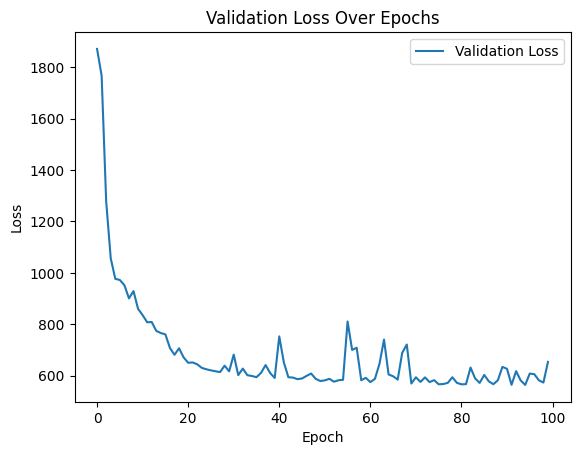

In [ ]:
# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
#evaluate model on test data
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 653.9177 - mae: 653.9177


[653.917724609375, 653.917724609375]

## Make forecasts with the model

Lets write a function which:
* Takes in a trained model (just like model_1)
* Takes in some input data (just like the data the model was trained on)
* Passes the input data to the model's predict() method
* Returns the predictions

In [ ]:
def make_preds(model,input_data):
  '''
  uses model to make predictions on input data

  parameters
  -----------
  model:trained model
  input data: windowed input data - same kind of data the model was trained on

  returns model predictions on input data
  '''
  forecast=model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
#make predictions on model_1 on the test dataset and view the results
model_1_preds=make_preds(model_1,test_windows)
len(model_1_preds),model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8711.17 , 8626.956, 8886.512, 8642.688, 8604.556, 8614.704,
        8531.594, 8385.565, 8330.601, 8388.003], dtype=float32)>)

In [ ]:
#evaluate predictions
model_1_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_1_preds)
model_1_results

{'mae': 653.9177,
 'mse': 1346904.0,
 'rmse': 1160.5619,
 'mape': 2.9842222,
 'mase': 1.1487523}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

it looks like our naive model beats our first deep model on every metric

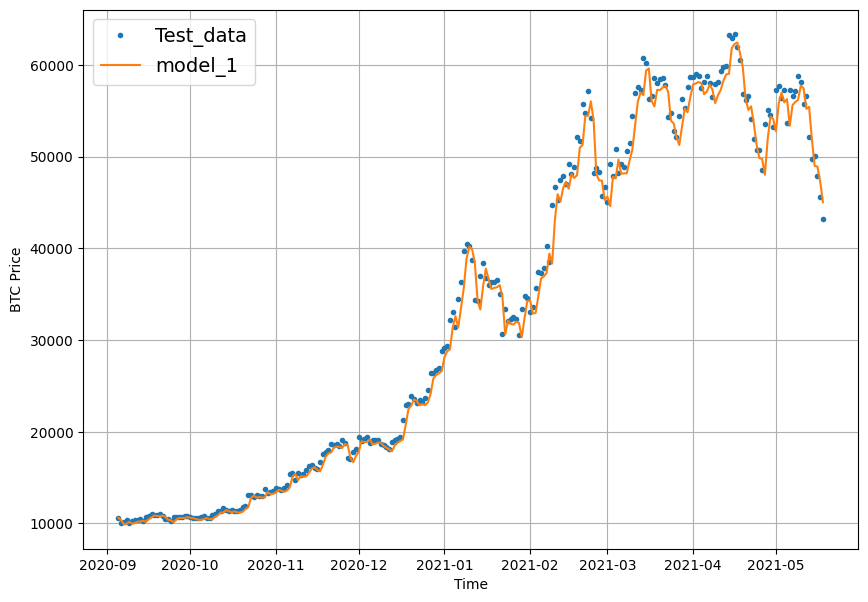

In [ ]:
#Lets visualize the results
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1")

What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.

With our current model setup, how do you think we'd make forecasts for the future?

Have a think about it for now, we'll cover this later on.

# Model 2: Dense model (Window=30,horizon=1)

In [ ]:
HORIZON=1
WINDOW_SIZE=30

In [ ]:
#make windowed data with appropiate horizon and window sizes
full_windows,full_labels=make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(2757, 2757)

In [ ]:
#make train and testing windows
train_windows,test_windows,train_labels,test_labels=make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(2205, 552, 2205, 552)

Lets construct model 2 with the same architecture as model 1


In [ ]:
tf.random.set_seed(42)

#create model (same as model 1 except data input will be different)
model_2=tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON)
],name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
#fit the model
history_2=model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            #callbacks=[[early_stopping]]
            )

Epoch 1/100
18/18 [==============================] - 1s 12ms/step - loss: 1345.0161 - val_loss: 4008.7681
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 362.9505 - val_loss: 1186.9210
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 205.3002 - val_loss: 1021.3676
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 190.1193 - val_loss: 1044.4911
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 180.6895 - val_loss: 1154.0215
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 192.6142 - val_loss: 1054.1637
Epoch 7/100
18/18 [==============================] - 0s 8ms/step - loss: 167.3156 - val_loss: 982.6846
Epoch 8/100
18/18 [==============================] - 0s 8ms/step - loss: 181.8609 - val_loss: 942.1515
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 170.2371 - val_loss: 917.9746
Epoch 10/100
18/18 [==============================] - 0s 8ms/step

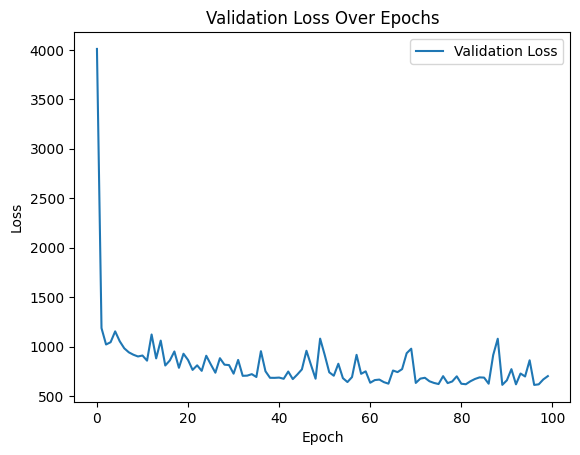

In [ ]:
# Plot validation loss
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
#evaluate the model 2 predictions
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 701.8038


701.8038330078125

In [ ]:
#get forecast predictions
model_2_preds=make_preds(model_2,input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 701.8038,
 'mse': 1555330.1,
 'rmse': 1247.1288,
 'mape': 3.2784984,
 'mase': 1.2267599}

In [ ]:
model_1_results,naive_results

({'mae': 653.9177,
  'mse': 1346904.0,
  'rmse': 1160.5619,
  'mape': 2.9842222,
  'mase': 1.1487523},
 {'mae': 567.9802,
  'mse': 1147547.0,
  'rmse': 1071.2362,
  'mape': 2.516525,
  'mase': 0.99957})

## make forecasts with the model

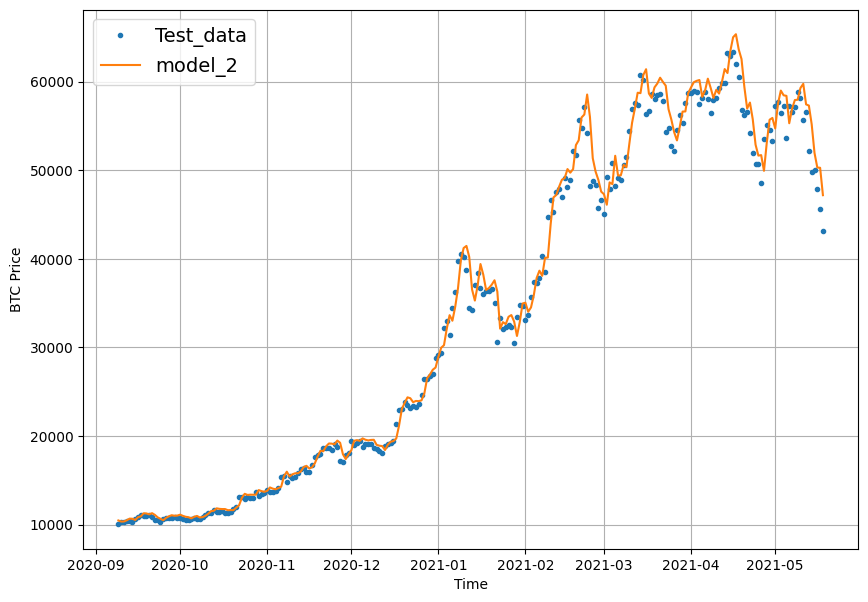

In [ ]:
#Lets visualize the results
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2")

cannot plot model 1 preds bc the windows are different thus different sizes

# Model 3: Dense model (window=30,horizon=7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            #callbacks=[create_model_checkpoint(model_name=model_3.name)]
            )

In [ ]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1326.3639


1326.3638916015625

Much higher error!

## Make predictions

In [ ]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9007.231, 9166.618, 9320.413, 9216.547, 9120.882, 9118.846,
        9272.709],
       [8768.854, 8825.585, 8903.567, 8818.52 , 8937.54 , 8929.412,
        9021.252],
       [8658.895, 8719.061, 8728.69 , 8782.68 , 8741.149, 8777.155,
        8777.639],
       [8906.982, 8853.74 , 8875.218, 8951.229, 8739.032, 8770.078,
        8814.605],
       [8702.48 , 8771.442, 8793.384, 8714.326, 8609.229, 8497.324,
        8709.078]], dtype=float32)>

In [ ]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 381.53445 ,  216.50279 ,  166.32115 ,  217.81752 ,  159.0978  ,
         273.68256 ,  294.49637 ,  238.09229 ,  374.71506 ,  415.756   ,
         510.31125 ,  539.6086  ,  654.8895  ,  711.77655 ,  454.90305 ,
         272.8863  ,  303.12088 ,  432.43246 ,  420.59467 ,  402.23557 ,
         189.47078 ,  113.95201 ,  121.143135,  133.03223 ,  143.5092  ,
         247.70877 ,  181.90695 ,  256.68375 ,  175.98758 ,   81.5971  ,
         136.34975 ,  197.34207 ,  107.70794 ,  167.13351 ,  163.86307 ,
         194.64627 ,  204.97412 ,  245.28976 ,  293.46436 ,  340.70438 ,
         694.5127  ,  289.8157  ,  186.38002 ,  220.58426 ,  100.68868 ,
         126.23891 ,  155.43758 ,  121.54095 ,  215.65646 ,  190.09201 ,
         182.29953 ,  144.48682 ,  145.78006 ,  245.47182 ,  396.63657 ,
         516.0239  ,  748.03326 ,  764.5472  ,  693.6481  ,  748.8754  ,
         579.25867 ,  418.33725 ,  321.79047 ,  616.8299  ,  707.2918  ,
         651.43945 ,  727.8729  ,  768.15643

### Make our evaluations function work for larger horizons

In [ ]:
'''
def evaluate_preds(y_true,y_pred):

  #make sure float32 for metric calculations
  y_true-tf.cast(y_true,dtype=tf.float32)
  y_pred=tf.cast(y_pred,dtype=tf.float32)

  #calculate various metrics
  mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse=tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse=tf.sqrt(mse)
  mape=tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase=mean_absolute_scaled_error(y_true,y_pred)

  #account for different sized metrics (for longer horizons to reduce to single number)
  if mae.ndim>0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}
'''



'\ndef evaluate_preds(y_true,y_pred):\n\n  #make sure float32 for metric calculations\n  y_true-tf.cast(y_true,dtype=tf.float32)\n  y_pred=tf.cast(y_pred,dtype=tf.float32)\n\n  #calculate various metrics\n  mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)\n  mse=tf.keras.metrics.mean_squared_error(y_true,y_pred)\n  rmse=tf.sqrt(mse)\n  mape=tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)\n  mase=mean_absolute_scaled_error(y_true,y_pred)\n\n  #account for different sized metrics (for longer horizons to reduce to single number)\n  if mae.ndim>0:\n    mae = tf.reduce_mean(mae)\n    mse = tf.reduce_mean(mse)\n    rmse = tf.reduce_mean(rmse)\n    mape = tf.reduce_mean(mape)\n    mase = tf.reduce_mean(mase)\n\n  return {"mae": mae.numpy(),\n          "mse": mse.numpy(),\n          "rmse": rmse.numpy(),\n          "mape": mape.numpy(),\n          "mase": mase.numpy()}\n'

In [ ]:

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1326.3639,
 'mse': 5689911.5,
 'rmse': 1507.5168,
 'mape': 5.8990145,
 'mase': 2.3601904}

If our prediction evaluation metrics were multidimensional, the predictions will be too

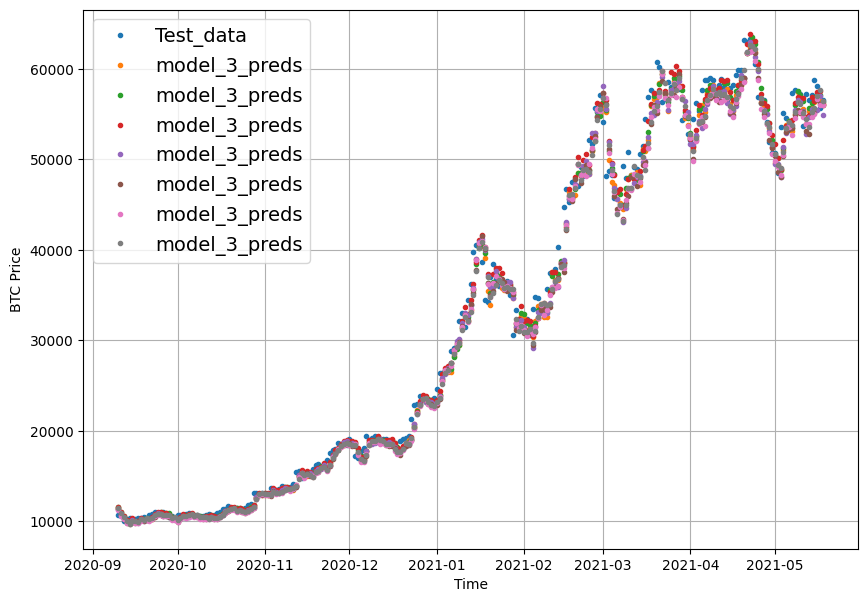

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

When we try to plot our multi-horizon predicts, we get a funky looking plot.

Again, we can fix this by aggregating our model's predictions.



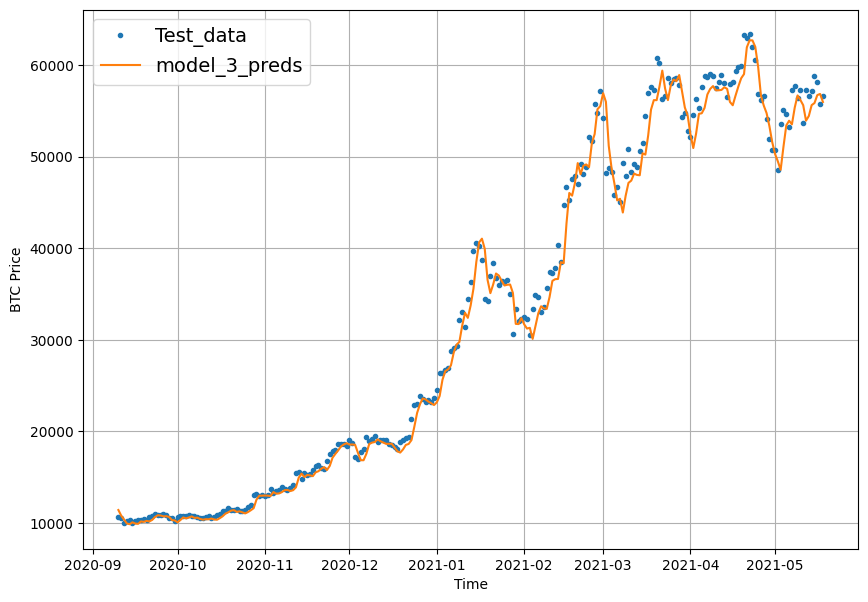

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look further ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

# Lets compare the performance of each of the models so far

<Axes: >

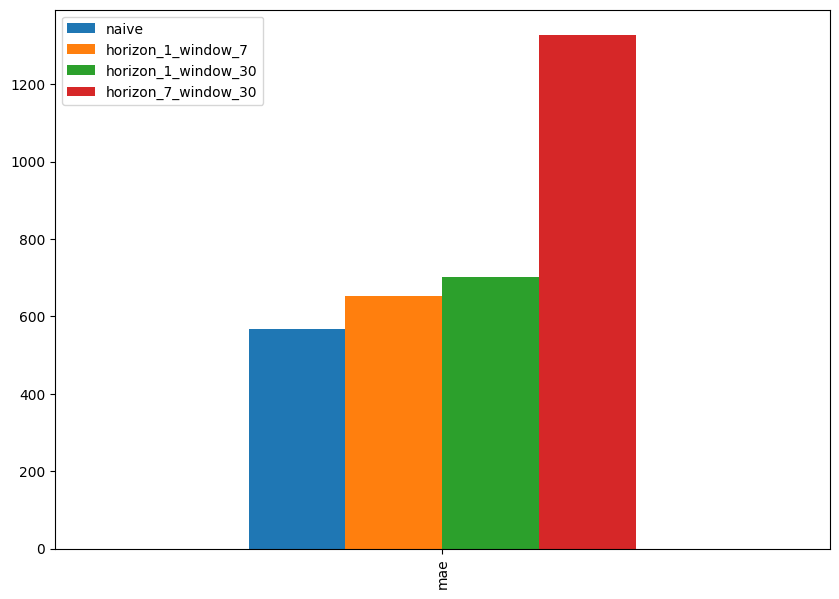

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar")

It looks like our naive model is working the best so far, its very hard to beat a naive model in open systems. This can be due to autocorrelation in the data where it means that the value at $t+1$ is typically close to the value at $t$, i.e. yesterdays value is close to todays.

For future models lets use horizon=1 and window=7 for the modeling experiments

# Model 4: Conv1D

This time, we'll be using a Conv1D model. Because as we saw in the sequence modelling notebook, Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case the input sequence is the previous 7 days of BTC price and the output is the next day (in seq2seq terms this is called to many to one problem)



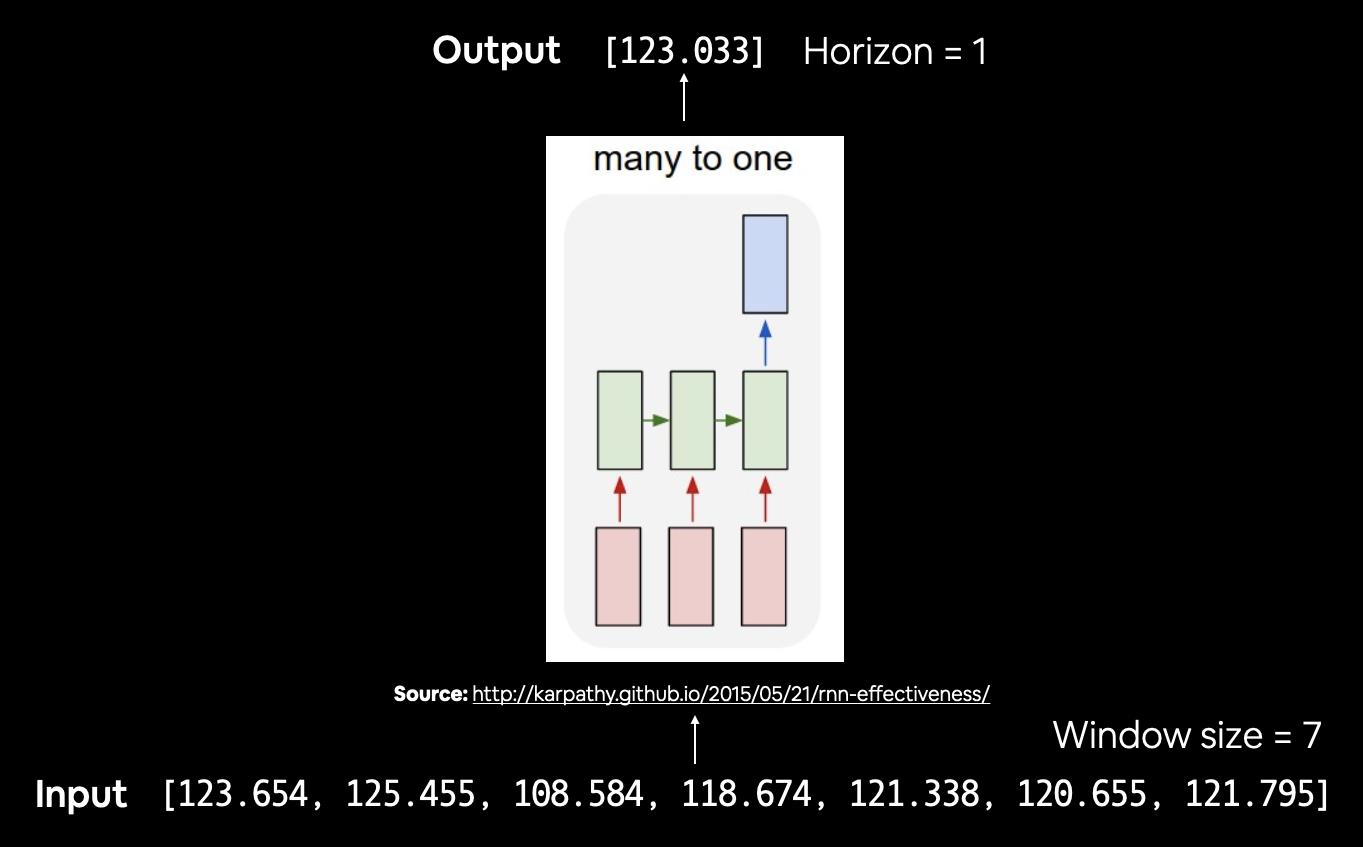

In [ ]:
HORIZON=1
WINDOW_SIZE=7

In [ ]:
#create windowed dataset
full_windows,full_labels=make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(2780, 2780)

In [ ]:
#create train/test splits
train_windows,test_windows,train_labels,test_labels=make_train_test_splits(full_windows,full_labels)
len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(2224, 556, 2224, 556)

Now that were going to be using Conv1Dlayers, we need to make sure our input shapes are correct. The Conv1D layer in TensorFlow takes an input of (batch_size,timesteps,input_dim)

We will use:
* batch_size=32 , this is the default
* timesteps=WINDOW_SIZE the timesteps is also referred to as features,out features are the previous WINDOW_SIZE values of BTC
* input_dim=HORIZON our model views WINDOW_SIZE (one week) worth of data at a time to predict HORIZON (one day)

Right now, our data has the timesteps dimension ready but we'll have to adjust it to have the input_dim dimension.

In [ ]:
#check data sample shapes
train_windows[0].shape #return (WINDOW_SIZE,)

(7,)

To fix this, we could adjust the shape of all of our train_windows or we could use a tf.keras.layers.Lamdba (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

In [ ]:
#before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x=tf.constant(train_windows[0])
expand_dims_layer=layers.Lambda(lambda x: tf.expand_dims(x,axis=1)) #add an extra dimension for timesteps

print(f"original shape: {x.shape}")
print(f"expanda shape: {expand_dims_layer(x).shape}")
print(f"original values with expanded shape:\n{expand_dims_layer(x)}")

original shape: (7,)
expanda shape: (7, 1)
original values with expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
'''
#set random seed
tf.random.set_seed(42)

#create model
model_4=tf.keras.Sequential([
    #create lambda layer to reshape inputs,without this layer, the model will error
    layers.Lambda(lambda x: tf.expand_dims(x,axis=1)), #resize the inputs to adjust for window size/Conv1D 3D input requirements
    layers.Conv1D(filters=128, kernel_size=5, padding="casual", activation="relu"),
    layers.Dense(HORIZON)
],name="model_4_conv1D")

#compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

'''

'\n#set random seed\ntf.random.set_seed(42)\n\n#create model\nmodel_4=tf.keras.Sequential([\n    #create lambda layer to reshape inputs,without this layer, the model will error\n    layers.Lambda(lambda x: tf.expand_dims(x,axis=1)), #resize the inputs to adjust for window size/Conv1D 3D input requirements\n    layers.Conv1D(filters=128, kernel_size=5, padding="casual", activation="relu"),\n    layers.Dense(HORIZON)\n],name="model_4_conv1D")\n\n#compile model\nmodel_4.compile(loss="mae",\n                optimizer=tf.keras.optimizers.Adam())\n                \n'

In [ ]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
#fit the model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows,test_labels),
            #callbacks=[create_model_checkpoint(model_name=model_4.name)]
            )

In [ ]:
#lets take a look at what the lambda layer looks like in summary
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#evaluate the model
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 658.0135


658.0135498046875

## make predictions

In [ ]:
#make predictions
model_4_preds=make_preds(model_4,test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8719.522 , 8630.127 , 8869.049 , 8630.128 , 8588.7295, 8609.832 ,
       8530.291 , 8362.066 , 8330.99  , 8375.411 ], dtype=float32)>

In [ ]:
#evaluate predictions
model_4_results=evaluate_preds(y_true=tf.squeeze(test_labels),
                               y_pred=model_4_preds)
model_4_results

{'mae': 658.0136,
 'mse': 1350713.4,
 'rmse': 1162.2019,
 'mape': 3.0115247,
 'mase': 1.1559477}

# model 5: RNN (LSTM)

Let's reuse the same data we used for the Conv1D model, except this time we'll create an LSTM-cell powered RNN to model our Bitcoin data.

The most important steps for the LSTM model will be getting our data into the right shape. The tf.keras.layers.LSTM() layer takes a tensor with [batch,timestpes,feature] dimensions. The batch dimension gets taken care of for us but our data is currently only has the feature dimension (WINDOW_SIZE). To fix this just like we did with the Conv1D model, we can use a tf.keras.layers.Lambda() layer to adjust the shape of our input tensors to the LSTM layer

In [ ]:
tf.random.set_seed(42)

#Lets build an LSTM model with the functional API
inputs=layers.Input(shape=(WINDOW_SIZE))
x=layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs) #expand input dimension to be compatible with LSTM
#print(x.shape)
#x=layers.LSTM(128,activation="relu",return_sequences=True)(x) #this layer will error if the inputs are not the right shape
x=layers.LSTM(128,activation="relu",return_sequences=True)(x) #using tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output=layers.Dense(HORIZON)(x)
model_5=tf.keras.Model(inputs=inputs,outputs=output,name="model_5_lstm")

#compile model
model_5.compile(loss="mae",optimizer=tf.keras.optimizers.Adam())

In [ ]:
# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            #callbacks=[create_model_checkpoint(model_name=model_5.name)]
            )

In [ ]:
#evaluate the model
model_5.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 619.0577


619.0576782226562

## make predictions

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9046.939, 8895.441, 9018.753, 8881.914, 8835.377, 8817.842,
       8756.45 , 8650.446, 8543.175, 8578.349], dtype=float32)>

In [ ]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 619.0577,
 'mse': 1340364.8,
 'rmse': 1157.7412,
 'mape': 2.8325238,
 'mase': 1.0875129}

# ^^ end of univariate time series

# make a multivarite time series

so far all of them have been trained on a single variable (also called univariate time series): the historical price of Bitcoin. If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.

we could try to see if the Bitcoin block reward size adds any predictive power to our model(s). (The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.)


Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from univariate (only the historical price of Bitcoin) to multivariate (the price of Bitcoin as well as the block reward size).

# Create multivaraite time series data

In [ ]:
#lets make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


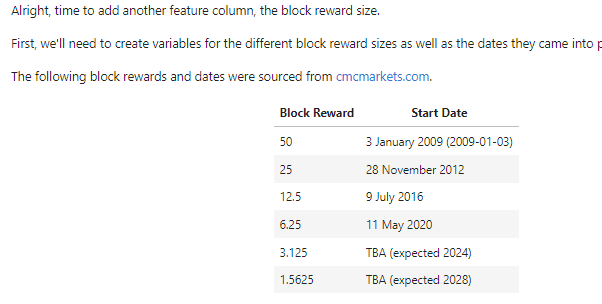

## add second column to BTC price column

In [ ]:
#block reward values
block_reward_1=50
block_reward_2=25
block_reward_3=12.5
block_reward_4=6.25

#block reward dates (datetime from the above date stamps)
block_reward_2_datetime=np.datetime64("2012-11-28")
block_reward_3_datetime=np.datetime64("2016-07-09")
block_reward_4_datetime=np.datetime64("2020-05-11")

We're going to get the days (indexes) for different block reward values.

This is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model

In [ ]:
#get date index for when to add in different block dates
block_reward_2_days=(block_reward_3_datetime-bitcoin_prices.index[0]).days
block_reward_3_days=(block_reward_4_datetime-bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:
#Now we can add another feature to our dataset block_reward (this gets lower over time so it may lead to increasing prices of Bitcoin).

#add block reward column
bitcoin_prices_block=bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

#set values of block reward column (if its the last column hence the -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


## visualize the 2 coumns data and normalize data



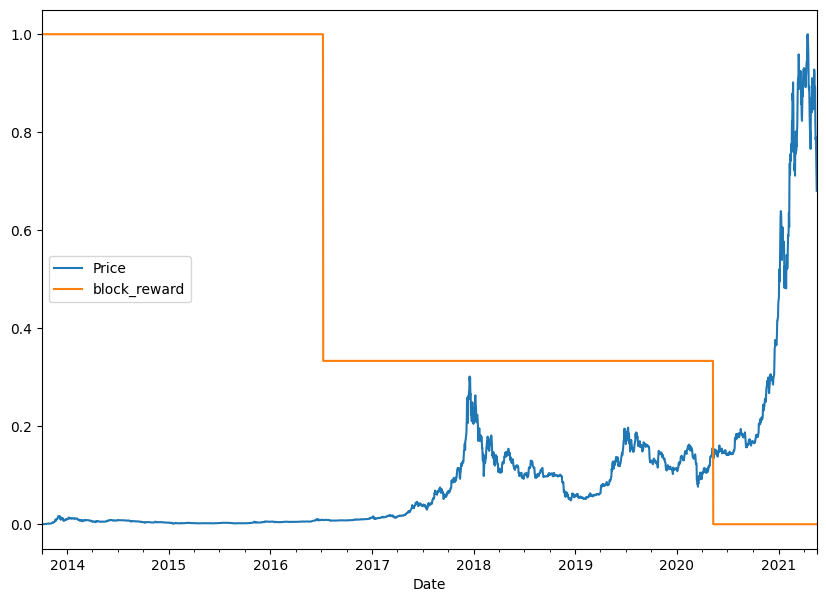

In [ ]:
#lets visualize
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

# Making a windowed dataset with pandas

We cant use the same functions we used in our univariate time series models. However we can use, pandas.DataFrame.shift() method to create a windowed multivariate time series



In [ ]:
#setup dataset hyperparameters
HORIZON=1
WINDOW_SIZE=7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed=bitcoin_prices_block.copy()

#add windowed columns
for i in range(WINDOW_SIZE): #shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"]=bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


## Split windowed dataset into X and y

Now that we have our data lets seperate features X and labels Y.

REMEMBER: we are trying to use the previous WINDOW_SIZE steps to predict HORIZON steps.
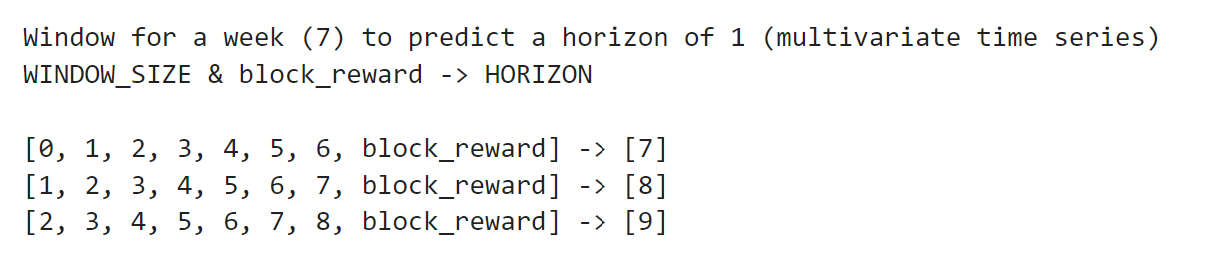



We'll also remove the Nan values using pandas dropna() method. This drops all rows with NaN values.

This equivalent to starting our windowing function at sample 0 (the first sample) + WINDOW_SIZE

In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head(10)

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661
2013-10-13,25.0,125.927498,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327
2013-10-14,25.0,126.383331,125.927498,125.279663,125.961159,124.049004,123.032997,121.794998
2013-10-15,25.0,135.241989,126.383331,125.927498,125.279663,125.961159,124.049004,123.032997
2013-10-16,25.0,133.203323,135.241989,126.383331,125.927498,125.279663,125.961159,124.049004


In [ ]:
#view labels
y.head(10)

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
2013-10-13    126.383331
2013-10-14    135.241989
2013-10-15    133.203323
2013-10-16    142.763336
2013-10-17    137.923325
Name: Price, dtype: float32

### split X and y into $X_{train,test}$ and $y_{train,test}$

In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

# Create model 6: Dense multivariate

To keep things simple lets use the model 1 architecture to train and make predictions on our multivariate time series data.

By replicating model_1 architecture we'll be able to see whether or not adding the block reward feature imrpoves or detract from model performance

In [ ]:
#set random seed
tf.random.set_seed(42)

#make multivariate time series model
model_6=tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON)
],name="model_6_dense_multivariate")

#compile the model
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
#fit the model
model_6.fit(X_train,y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test,y_test))

In [ ]:
#evaluate the model
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 3ms/step - loss: 640.6017


640.6017456054688

In [ ]:
#make predictions on multivariate data
model_6_preds=tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8734.277, 8654.5  , 8900.722, 8662.495, 8598.69 , 8598.799,
       8568.868, 8398.027, 8330.93 , 8406.101], dtype=float32)>

In [ ]:
#evaluate preds
model_6_results=evaluate_preds(y_true=y_test,
                               y_pred=model_6_preds)
model_6_results

{'mae': 640.60175,
 'mse': 1317888.9,
 'rmse': 1147.9934,
 'mape': 2.91302,
 'mase': 1.1253599}

In [ ]:
model_1_results

{'mae': 653.9177,
 'mse': 1346904.0,
 'rmse': 1160.5619,
 'mape': 2.9842222,
 'mase': 1.1487523}

In [ ]:
model_6_preds.shape

TensorShape([556])

In [ ]:
X.shape

(2780, 8)

In [ ]:
2780/556

5.0

In [ ]:
timesteps.shape

(2787,)